# Exercise 1
## Time Series Analysis & Recurrent Neural Networks, SoSe 2021
### Author: Elias Olofsson
    Version information:
        2021-04-28: v.1.0. First public release. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

# Produce inline vector graphics
%config InlineBackend.figure_format = 'svg'

## Task 1: Weather

In [2]:
import pandas as pd
df = pd.read_csv('dailyweather.csv', sep=',')
df.head()

,Time,Temperature,Humidity,Pressure
0,2016,3.8,95.0,1028.3
1,2016,4.3,92.0,1016.0
2,2016,4.7,92.0,1009.1
3,2016,4.6,89.0,995.9
4,2016,5.1,89.0,998.4


In [3]:
# Extracting each individual time series.
time        = df['Time'].values
temperature = df['Temperature'].values
humidity    = df['Humidity'].values
pressure    = df['Pressure'].values

print(time.shape, temperature.shape, humidity.shape, pressure.shape)

(1827,) (1827,) (1827,) (1827,)


In [4]:
print(np.unique(time, return_counts=True))

(array([2016, 2017, 2018, 2019, 2020]), array([366, 365, 365, 365, 366]))


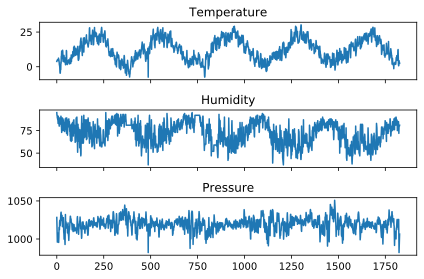

In [5]:
# Plotting the time series.
fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].plot(temperature)
ax[0].set_title('Temperature')
ax[1].plot(humidity)
ax[1].set_title('Humidity')
ax[2].plot(pressure)
ax[2].set_title('Pressure')

fig.tight_layout()
plt.show()

### 1.1 Correlation

In [6]:
def gamma(x, y):
    """
    Calculate the covariance between time series x and y.
    """
    return ((x-x.mean())*(y-y.mean())).mean()

def var(x):
    """
    Variance of time series x.
    """
    return ((x-x.mean())**2).mean()

def shift(x, y, dt):
    """
    Shift time series x and y relative to each other
    for dt integer time steps. 
    """
    if dt > 0:
        x = x[:-dt]
        y = y[dt:]
    elif dt < 0:
        x = x[abs(dt):]
        y = y[:-abs(dt)]
    return x, y

def xcov(x, y, dt=0):
    """
    Cross-covariance between x and y, given time-lag dt.
    """
    x, y = shift(x, y, dt)
    return gamma(x, y)

def xcorr(x, y, dt=0):
    """
    Cross-correlation between x and y, given time-lag dt.
    """
    x, y = shift(x, y, dt)
    return gamma(x, y) / (np.sqrt(var(x)) * np.sqrt(var(y)))

def acov(x, dt=0):
    """
    Auto-covariance of x, given time-lag dt.
    """
    return xcov(x, x, dt)

def acorr(x, dt=0):
    """
    Auto-correlation of x, given time-lag dt.
    """
    return xcorr(x, x, dt)

def sweep(method, n, **args):
    """
    Sweep over relative time-lags dt between x and y in the range [-n, n), 
    and calculate the given quantitiy (eg. xcorr, acov) for the entire range.  
    """
    out = np.zeros(2*n)
    for i, dt in enumerate(list(range(-n, n))):
        out[i] = method(**args, dt=dt)
    return out

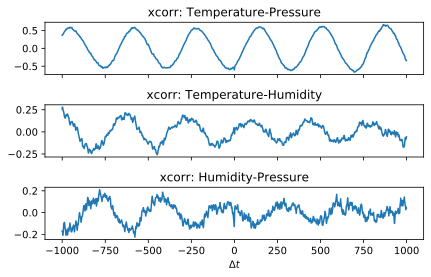

In [7]:
# Range of time-lags.
n = 1000
dt = np.arange(-n, n)

# Cross-correlation: temp-humidity.
xcorr_temp_pres = sweep(xcorr, n, x=temperature, y=humidity)

# Cross-correlation: temp-pressure.
xcorr_temp_hum = sweep(xcorr, n, x=temperature, y=pressure)

# Cross-correlation: humidity-pressure.
xcorr_hum_pres = sweep(xcorr, n, x=humidity, y=pressure)

# Plotting.
fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].plot(dt, xcorr_temp_pres)
ax[0].set_title('xcorr: Temperature-Pressure')
ax[1].plot(dt, xcorr_temp_hum)
ax[1].set_title('xcorr: Temperature-Humidity')
ax[2].plot(dt, xcorr_hum_pres)
ax[2].set_title('xcorr: Humidity-Pressure')
ax[2].set_xlabel('$\Delta t$')
fig.tight_layout()
plt.show()

### 1.2 Return plots

In [8]:
def return_plot_data(x, order):
    """
    Generate x and y data for an n:th order return plot.
    """
    x_out = x[:-order]
    y_out = x[order:]
    return [x_out, y_out]

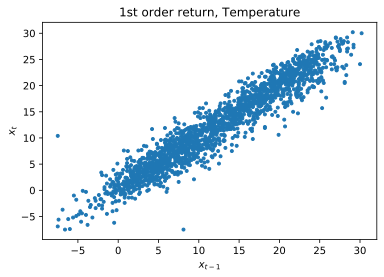

In [9]:
plt.plot(*return_plot_data(temperature, 1), '.')
plt.xlabel('$x_{t-1}$')
plt.ylabel('$x_{t}$')
plt.title('1st order return, Temperature')
plt.show()

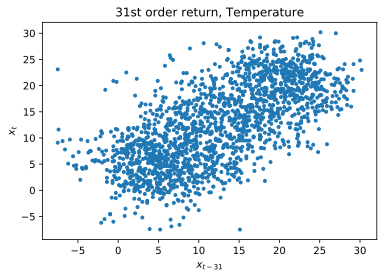

In [10]:
plt.plot(*return_plot_data(temperature, 31), '.')
plt.xlabel('$x_{t-31}$')
plt.ylabel('$x_{t}$')
plt.title('31st order return, Temperature')
plt.show()

### 1.3 Temperature trend

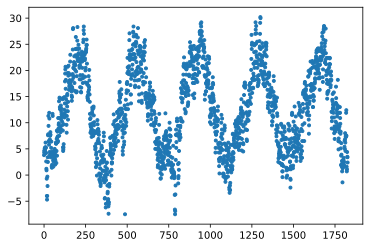

In [11]:
plt.plot(temperature, '.')
plt.show()

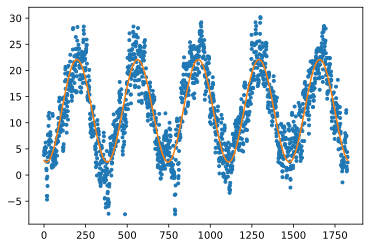

In [12]:
from scipy import optimize

def sin_func(x, a, w, m, b):
    return a * np.sin(w * x + m) + b 

# Least squares fit of sinusoidal function
params, params_covariance = optimize.curve_fit(sin_func, np.arange(len(temperature)), temperature,
                                               p0=[20, 0.0172, 0, 10])
plt.plot(temperature, '.')
plt.plot(np.arange(len(temperature)), sin_func(np.arange(len(temperature)), *params),
         label='Fitted function')
plt.show()

In [13]:
# Frequency guess:
1/365*2*np.pi

0.01721420632103996

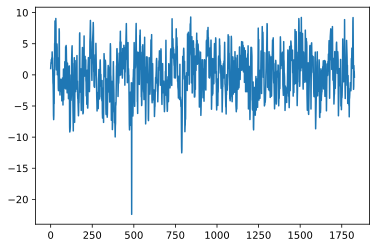

In [14]:
# Removing yearly oscillations from original time series. 
temp_new = temperature - sin_func(np.arange(len(temperature)), *params)
plt.plot(temp_new)
plt.show()

## Task 2: Detrending and auto-correlation

In [15]:
df2 = pd.read_excel(r'investment.xls', sheet_name='Sheet1')
df2.head()

,investment
0,0.001737
1,0.001683
2,0.001739
3,0.001866
4,0.001912


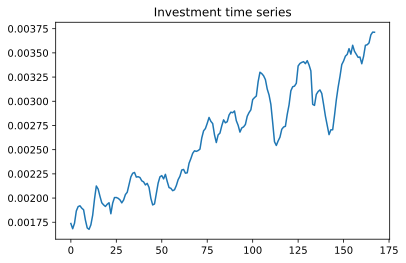

In [16]:
investment = df2.values.reshape(-1)
plt.plot(investment)
plt.title('Investment time series')
plt.show()

### 2.1 Removing trend

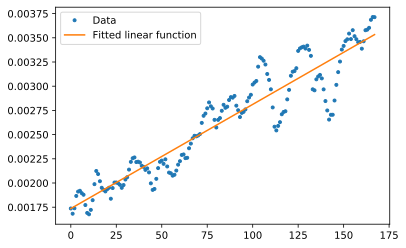

In [17]:
def lin_func(x, k, m):
    return k*x + m 

# Least squares fit of linear function
params, params_covariance = optimize.curve_fit(lin_func, np.arange(len(investment)), investment,
                                               p0=[0, 0])
plt.plot(investment, '.', label='Data')
plt.plot(np.arange(len(investment)), lin_func(np.arange(len(investment)), *params),
         label='Fitted linear function')
plt.legend()
plt.show()

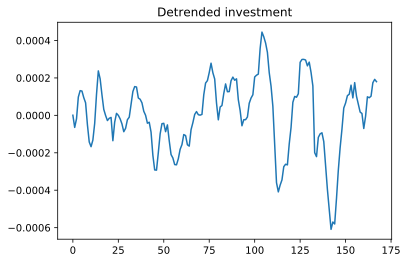

In [18]:
investment_new = investment - lin_func(np.arange(len(investment)), *params)
plt.plot(investment_new)
plt.title('Detrended investment')
plt.show()

### 2.2 Stationarity

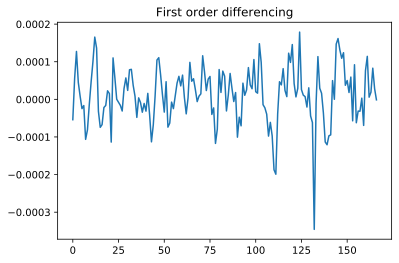

In [19]:
# First order differencing
investment_diff1 = investment[1:] - investment[:-1]
plt.plot(investment_diff1)
plt.title('First order differencing')
plt.show()

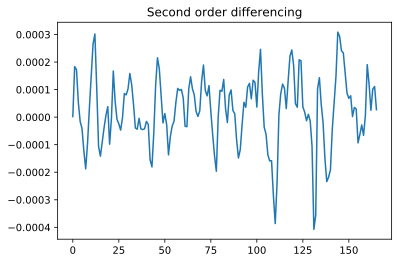

In [20]:
# Second order differencing
investment_diff2 = investment[2:] - investment[:-2]
plt.plot(investment_diff2)
plt.title('Second order differencing')
plt.show()

### 2.3 Auto-correlation

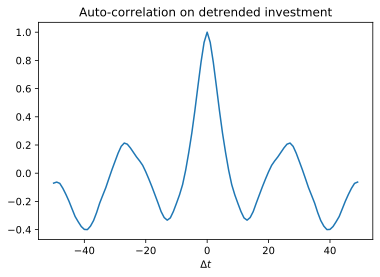

In [21]:
n = 50
acorr_inv_new = sweep(acorr, n, x=investment_new)
plt.plot(np.arange(-n, n), acorr_inv_new)
plt.title('Auto-correlation on detrended investment')
plt.xlabel('$\Delta t$')
plt.show()

## Task 3: AR models

In [22]:
T = 200                             # Length of time series.
p = 4                               # Order of AR model.
a = np.array([0, -0.8, 0, 0, 0.4])  # AR model coefficients (a_i = a[i])
eps = np.random.normal(size=T)      # eps ~ N(0,1)
x_init = 0                          # Inital value of the time series.

x = np.zeros(T)
x[0] = x_init

In [23]:
for t in range(1, T):
    if t < len(a):
        x_tmp = np.zeros_like(a[1:])
        x_tmp[:t] = x[t-1::-1]
        x[t] = a[0] + a[1:].dot(x_tmp) + eps[t]
    else:
        x[t] = a[0] + a[1:].dot(x[t-1:t-len(a):-1]) + eps[t]

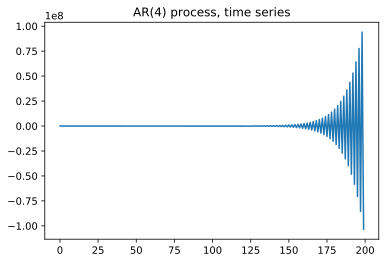

In [24]:
plt.plot(x)
plt.title('AR(4) process, time series')
plt.show()

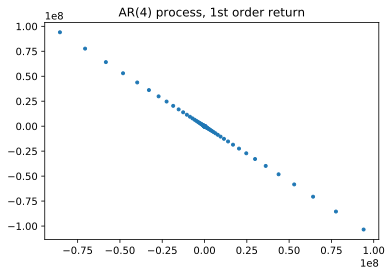

In [25]:
plt.plot(*return_plot_data(x, 1), '.')
plt.title('AR(4) process, 1st order return')
plt.show()

In [ ]:
as